## Импорт библиотек

In [1]:
# для работы с датафреймами
import pandas as pd

# для визуализации результатов
import matplotlib.pyplot as plt

# для работы с массивами
import numpy as np

# для работы с файловой системой
import os, shutil

# модуль со словарями
from collections import defaultdict

# для создания прогресс-бара
from tqdm import tqdm

# nlp библиотека
import nltk
# модуль со стоп словами
from nltk.corpus import stopwords

# для создания облаков слов
from wordcloud import WordCloud

# модуль с регулярными приложениями
import re

# для работы со строками
import string

# 
from datasets import Dataset, DatasetDict

# вспомогательные функции 
from function import *

c:\Users\user1\NLP\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# функция для показа примеров
def show_samples(dataset, num_samples: int = 3, seed: int = 42):
    # собираем указанное кол-во примеров
    samples = dataset['train'].shuffle(seed=seed).select(range(num_samples))
    # проходимся по каждому примеру
    for sample in samples:
        # вывод примеров
        print(f">> Статья: {sample['text'][:200]}...")
        print(f">> Аннотация: {sample['summary']}")


Для создания нашей двуязыковой суммаризации мы будем использовать Multilingual Amazon Reviews Corpus. Этот корпус состоит из отзывов о товарах Amazon на шести языках и обычно используется для тестирования многоязыковых классификаторов. Однако, поскольку каждый отзыв сопровождается коротким заголовком, мы можем использовать заголовки в качестве целевых резюме для обучения нашей модели! Чтобы начать работу, давайте загрузим английские и испанские подмножества из Hugging Face Hub:

In [6]:
# Использование
dataset = Dataset.from_list(reorganize_dataset("../Data/DATASET/"))
dataset

Dataset({
    features: ['text_path', 'annotation_path', 'tags_path', 'text', 'summary', 'tag', 'text_all_symb', 'summary_all_symb', 'tag_all_symb', 'text_clean', 'summary_clean', 'tag_clean', 'text_words', 'summary_words', 'tag_words', 'id'],
    num_rows: 1002
})

In [20]:
df = pd.DataFrame(dataset)
# df.head()
df[['text_all_symb','text_clean']].head()

,text_all_symb,text_clean
0,5160,5061
1,6075,5917
2,6692,6586
3,5525,5356
4,12202,11905


In [29]:
df[['text_all_symb','text_clean', 'text_words']].describe()

,text_all_symb,text_clean,text_words
count,1002.000000,1002.000000,1002.000000
mean,9243.906188,8970.108782,1151.152695
std,8165.170347,7920.992738,1025.736130
min,0.000000,0.000000,0.000000
25%,5049.000000,4905.250000,638.250000
50%,7259.500000,7041.000000,898.500000
75%,10678.750000,10412.750000,1331.000000
max,111644.000000,108116.000000,14220.000000


       summary_all_symb  summary_clean  summary_words
count       1002.000000    1002.000000    1002.000000
mean         494.934132     485.199601      58.764471
std          390.030148     382.093134      46.548680
min            0.000000       0.000000       0.000000
25%          243.000000     240.000000      29.000000
50%          380.500000     374.000000      45.000000
75%          606.000000     593.000000      72.000000
max         4082.000000    4007.000000     488.000000


<Axes: >

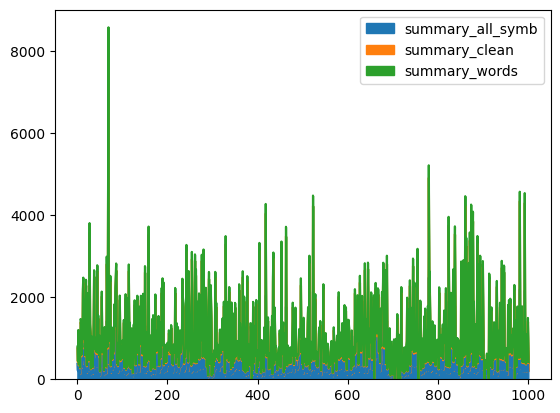

In [32]:
print(df[['summary_all_symb', 'summary_clean', 'summary_words']].describe())
df[['summary_all_symb', 'summary_clean', 'summary_words']].plot(kind='area')

array([<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
       <Axes: >, <Axes: >, <Axes: >], dtype=object)

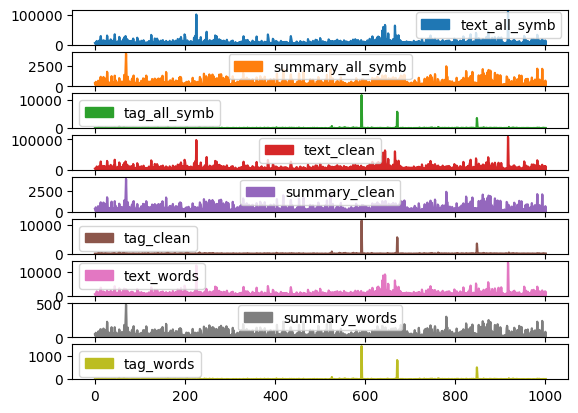

In [40]:
df.plot(kind='area', subplots=True)

<Axes: >

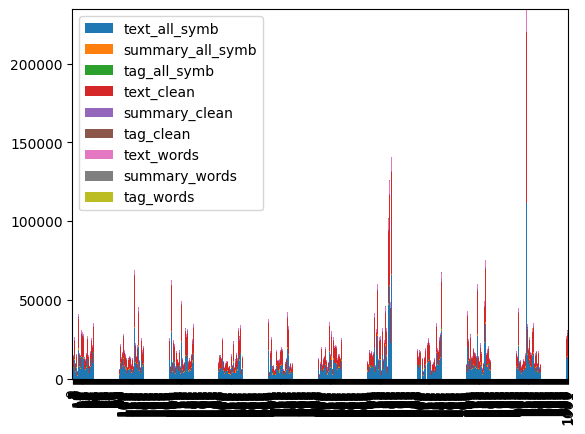

In [41]:
df.plot(kind='bar', stacked=True)

In [17]:
show_samples(dataset)

>> Статья: В
ыполнение инженерных изысканий (ИИ) для зданий
и сооружений нормального и повышенного уровня
ответственности на стадии архитектурно-строительного проектирования всегда было обязательным [1].
Требова...
>> Аннотация: В данной статье рассматривается вопрос об использовании результатов инженерных изысканий, выполненных на стадии планировки территории при подготовке проектной документации. Рассмотрены причины фактического отсутствия результатов инженерных изысканий в документации по планировке территории, а также механизмы преодоления сложившейся ситуации. Полноценные инженерные изыскания на стадии планировки территории позволят оптимизировать объем экспертиз и качество планировочных решений на стадии архитектурно-строительного проектирования, а также в полном объеме реализовать мероприятия, предусмотренные для проектов по возведению объектов капитального строительства.
>> Статья: Обучение курсантов – будущих морских специалистов для судов транспортного флота – осуществляется 

,text,summary,id
0,Вирусы наносят серьезный ущерб урожаю сельскох...,Культурные растения во всем мире подвергаются ...,846
1,Программирование – это всегда создание чего-то...,В данной статье рассматриваются 3 новейших фре...,747
2,Информационная безопасность представляет собой...,"Информация в современном мире ценится высоко, ...",126
3,CSS (Cascading Style Sheets) предназначен для ...,В статье рассматриваются основные типы селекто...,599
4,Робототехника стала неотъемлемой частью соврем...,В современном мире применение робототехники ст...,876


In [ ]:
def count_words(example):
    # Разделяем текст на слова (пробел как разделитель)
    words = example["text"].split()
    # Возвращаем количество слов
    return {"text_len": len(words)}

dataset = dataset.map(count_words)

In [ ]:
dataset = dataset.filter(lambda x: len(x['text']))